<center><h1>Quick Start Guide to Kaggle's <i>Titanic: Machine Learning from Disaster<i></h1></center>

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
sns.set(rc={'figure.figsize': (9, 7)})
np.random.RandomState(seed=42);
# print(os.listdir('../input'));

## 0. Data Retrieval

### Load Datasets

In [2]:
# load training and testing datasets using pandas.read_csv() 
train, test = pd.read_csv('data/train.csv'), pd.read_csv('data/test.csv')

# Print the shapes of both training and testing datasets
print('Training Dataset: %s, Testing Dastaset: %s' %(str(train.shape), str(test.shape)))

# Inspect column dtypes
train.dtypes.reset_index()

Training Dataset: (891, 12), Testing Dastaset: (418, 11)


,index,0
0,PassengerId,int64
1,Pclass,int64
2,Name,object
3,Sex,object
4,Age,float64
5,SibSp,int64
6,Parch,int64
7,Ticket,object
8,Fare,float64
9,Cabin,object


## 1. Data Preparation

### Data Processing & Wrangling, Exploratory Data Analysis

In [3]:
# Detect potential outliers in our training dataset using z scores
def outliers_z_score(series, threshold=3):
    outliers = list()
    mean_, std_, threshold = np.mean(series), np.std(series), threshold
    z_scores = [(elem - mean_) / std_ for elem in series]
    return series[np.abs(z_scores) > threshold] 

In [4]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
outlier_ind = list()
for num_feature in numeric_features:
    outliers = outliers_z_score(train[num_feature])
    index_outliers = list(outliers.index)
    outlier_ind += index_outliers

In [5]:
train = train.drop(list(set(outlier_ind)), axis=0).reset_index(drop=True)  # Drop outliers via indices
train_PassengerId, test_PassengerId = train['PassengerId'], test['PassengerId']  # Store PassengerIds for training and testing sets
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)  # Merge training and testing sets

In [6]:
dataset = dataset.fillna(np.nan)  # Fill in empty values with NaN
dataset.isnull().sum()  # See which columns have NaN values

Age            254
Cabin          966
Embarked         2
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

In [7]:
train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,825.000000,825.000000,657.000000,825.000000,825.000000,825.000000,825.000000
mean,445.596364,2.306667,30.126591,0.347879,0.254545,25.889661,0.387879
std,255.327509,0.828361,14.030821,0.618445,0.564467,29.792940,0.487562
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,226.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,447.000000,3.000000,28.500000,0.000000,0.000000,13.000000,0.000000
75%,662.000000,3.000000,38.000000,1.000000,0.000000,27.720800,1.000000
max,891.000000,3.000000,71.000000,3.000000,2.000000,164.866700,1.000000


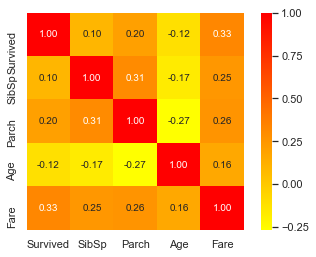

In [8]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), 
            annot=True, fmt='.2f', cmap='autumn_r', square=True);

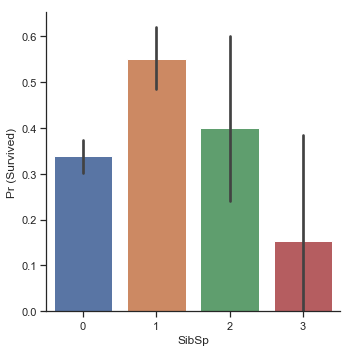

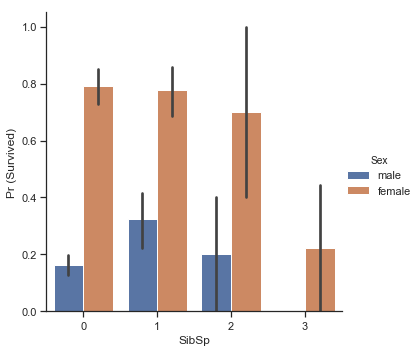

In [9]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('SibSp', 'Survived', data=train, kind='bar')
    g.set_axis_labels('SibSp', 'Pr (Survived)')
    g = sns.catplot('SibSp', 'Survived', 'Sex', data=train, kind='bar')
    g.set_axis_labels('SibSp', 'Pr (Survived)');

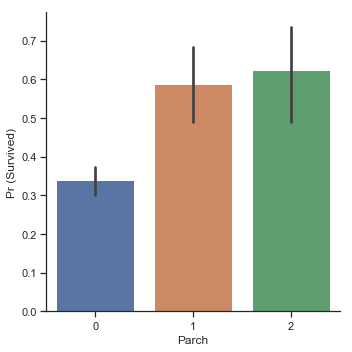

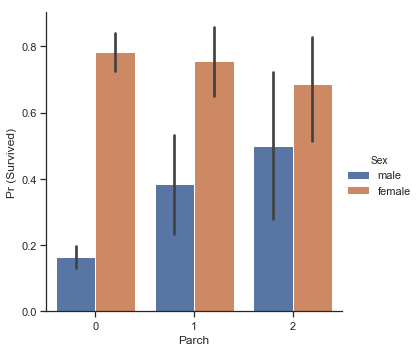

In [10]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('Parch', 'Survived', data=train, kind='bar')
    g.set_axis_labels('Parch', 'Pr (Survived)')
    g = sns.catplot('Parch', 'Survived', 'Sex', data=train, kind='bar')
    g.set_axis_labels('Parch', 'Pr (Survived)');

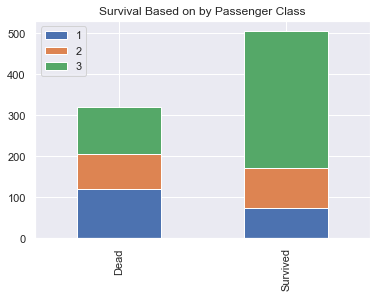

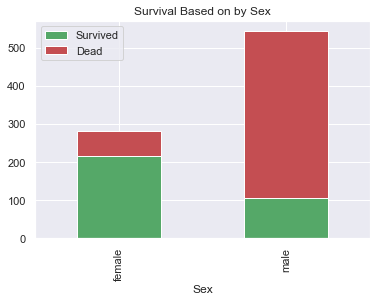

In [11]:
# Compare number of dead versus survived
survivors = train[train['Survived'] == 1]['Pclass'].value_counts()
dead = train[train['Survived'] == 0]['Pclass'].value_counts()
df_survival_pclass = pd.DataFrame([survivors, dead])
df_survival_pclass.index = ['Dead', 'Survived']
df_survival_pclass.plot(kind='bar', stacked=True, title='Survival Based on by Passenger Class')
train['Dead'] = 1 - train['Survived']
train.groupby('Sex').agg('sum')[['Survived', 'Dead']].plot(kind='bar', stacked=True, color=['g', 'r'], title='Survival Based on by Sex');

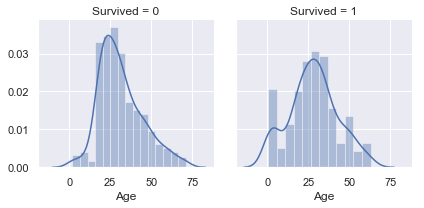

In [12]:
g = sns.FacetGrid(train, col='Survived')
g.map(sns.distplot, 'Age');

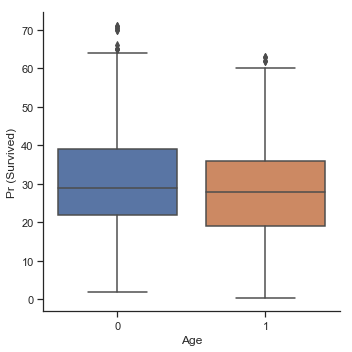

In [13]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
    g.set_axis_labels('Age', 'Pr (Survived)');

### Feature Engineering & Scaling, Feature Selection

In [14]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
dataset['Embarked'] = dataset['Embarked'].fillna('S')

nan_age_index = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in nan_age_index:
    age_similar = dataset['Age'][(dataset['SibSp'] == dataset.loc[i]['SibSp']) & 
                   (dataset['Parch'] == dataset.loc[i]['Parch']) & 
                   (dataset['Pclass'] == dataset.loc[i]['Pclass'])].median()
    age_median = dataset['Age'].median()
    
    if not np.isnan(age_similar):
         dataset['Age'].loc[i] = age_similar
    else:
        dataset['Age'].loc[i] = age_median

In [15]:
encoder_embarked, encoder_sex = LabelEncoder(), LabelEncoder()

encoder_embarked.fit(dataset['Embarked'])
encoder_sex.fit(dataset['Sex'])

dataset['Embarked'] = encoder_embarked.transform(dataset['Embarked'])
dataset['Sex'] = encoder_sex.transform(dataset['Sex'])

In [16]:
# Combine 'SibSp' and 'Parch' => 'Relatives'
dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']

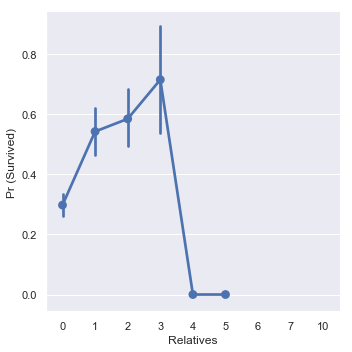

In [17]:
g = sns.factorplot(x='Relatives', y='Survived', data=dataset)
g.set_axis_labels('Relatives', 'Pr (Survived)');

In [18]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [19]:
scaler_age, scaler_age = StandardScaler(), StandardScaler()
dataset['Age'] = scaler_age.fit_transform(np.array(dataset['Age']).reshape(-1, 1))
dataset['Fare'] = scaler_age.fit_transform(np.array(dataset['Fare']).reshape(-1, 1))

In [20]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Sex', 
            'SibSp', 'Relatives', 'Pc_1', 'Pc_2', 'Pc_3']

## 2. Modeling

### Model Selection

In [21]:
train = dataset[dataset['PassengerId'].isin(train_PassengerId)]
test = dataset[dataset['PassengerId'].isin(test_PassengerId)]

In [22]:
train['Survived'] = train['Survived'].astype(int)
test.drop(labels=['Survived'], axis=1,inplace=True)
train, test, train_survived = train[features], test[features], train['Survived']
X_train, y_train = train.values, train_survived.values
X_test = test.values

In [23]:
kfold = StratifiedKFold(n_splits=10)
estimators = [AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1),
              DecisionTreeClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(),
              KNeighborsClassifier(), LinearDiscriminantAnalysis(), LogisticRegression(),
              MLPClassifier(), RandomForestClassifier(), SVC(), XGBClassifier()]

classifiers = list()
for est in estimators:
    classifiers.append(est)

In [24]:
%%capture
cross_val_results = []
for classifier in classifiers :
    cross_val_results.append(cross_val_score(classifier, X_train, y_train, 
                                             scoring='accuracy', cv=kfold))
    
cross_val_means, cross_val_stds = [], []
for cv_result in cross_val_results:
    cross_val_means.append(cv_result.mean())
    cross_val_stds.append(cv_result.std())
    
df_cv = pd.DataFrame({'CrossValMeans':cross_val_means,
                      'CrossValErrors': cross_val_stds,
                      'Algorithms':['AdaBoost', 'DecisionTree', 'ExtraTrees', 'GradientBoosting',
                                    'KNeighboors', 'LinearDiscriminantAnalysis', 'LogisticRegression',
                                    'MultipleLayerPerceptron', 'RandomForest', 'SVC', 'XGBClassifier']})

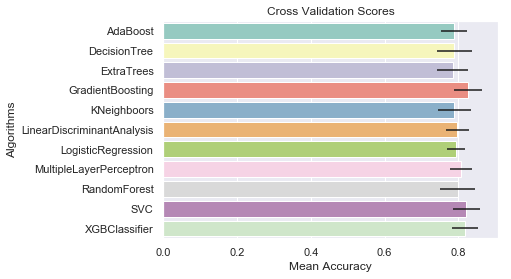

In [25]:
g = sns.barplot('CrossValMeans', 'Algorithms', data=df_cv, 
                palette='Set3', orient='h', **{'xerr':cross_val_stds})
g.set_xlabel('Mean Accuracy')
g.set_title('Cross Validation Scores');

In [26]:
possible_models = df_cv.sort_values(by=['CrossValMeans'], ascending=False).reset_index(drop=True)
print(possible_models)

    CrossValMeans  CrossValErrors                  Algorithms
0        0.825478        0.038321            GradientBoosting
1        0.821775        0.035406                         SVC
2        0.818190        0.035966               XGBClassifier
3        0.806068        0.029602     MultipleLayerPerceptron
4        0.797693        0.046996                RandomForest
5        0.796371        0.031025  LinearDiscriminantAnalysis
6        0.792742        0.023808          LogisticRegression
7        0.789171        0.047371                DecisionTree
8        0.789171        0.043854                 KNeighboors
9        0.787878        0.034273                    AdaBoost
10       0.784264        0.042438                  ExtraTrees


### Model Evaluation and Tuning

In [27]:
estimator_scores = dict()

In [28]:
# AdaBoost Classifier
dec_tree_est = DecisionTreeClassifier()
clf_AdaBoost_DTC = AdaBoostClassifier(dec_tree_est)

parameters_ada_tree = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__splitter': ['best', 'random'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'n_estimators': [1, 2]
}

clf_ada_tree = GridSearchCV(clf_AdaBoost_DTC, parameters_ada_tree, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_ada_tree.fit(X_train, y_train)

clf_ada_tree_best = clf_ada_tree.best_estimator_
estimator_scores[clf_ada_tree.best_score_] = clf_ada_tree_best
print('Best score: ', clf_ada_tree.best_score_)
print('Best params: ', clf_ada_tree.best_params_);

Best score:  0.8048484848484848
Best params:  {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'learning_rate': 0.2, 'n_estimators': 2}


In [29]:
# Extra Trees Classifier
clf_ExtraTrees = ExtraTreesClassifier()

parameters_extra_trees = {
    'bootstrap': [False],
    'criterion': ['gini'],
    'max_features': [1, 3, 10],
    'min_samples_leaf': np.linspace(0.1, 0.5, 4),
    'n_estimators': [300],
    'max_depth': [None]
}

clf_extra_trees = GridSearchCV(clf_ExtraTrees, parameters_extra_trees, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_extra_trees.fit(X_train, y_train)

clf_extra_trees_best = clf_extra_trees.best_estimator_
estimator_scores[clf_extra_trees.best_score_] = clf_extra_trees_best
print('Best score: ', clf_extra_trees.best_score_)
print('Best params: ', clf_extra_trees.best_params_);

c:\users\peter\anaconda3\envs\mne\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score:  0.7927272727272727
Best params:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 0.1, 'n_estimators': 300}


In [30]:
# Gradient Boosting Classifier
clf_GradientBoost = GradientBoostingClassifier()

parameters_gradient_boost = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'loss': ['deviance'],
    'max_depth': [3, 5, 8],
    'max_features': ['log2', 'sqrt'],
    'n_estimators': [300]
}

clf_gradient_boost = GridSearchCV(clf_GradientBoost, parameters_gradient_boost, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_gradient_boost.fit(X_train, y_train)

clf_gradient_boost_best = clf_gradient_boost.best_estimator_
estimator_scores[clf_gradient_boost.best_score_] = clf_gradient_boost_best
print('Best score: ', clf_gradient_boost.best_score_)
print('Best params: ', clf_gradient_boost.best_params_);

Best score:  0.8278787878787879
Best params:  {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 300}


In [31]:
# Multiple Layer Perceptron Classifier
clf_MLP = MLPClassifier()

parameters_MLP = {
    'alpha': [1e-2, 1e-3, 1e-4],
    'max_iter': np.arange(1000, 2001, 500),
    'hidden_layer_sizes': [10],
    'solver': ['lbfgs']
}

clf_mlp = GridSearchCV(clf_MLP, parameters_MLP, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_mlp.fit(X_train, y_train)

clf_mlp_best = clf_mlp.best_estimator_
estimator_scores[clf_mlp.best_score_] = clf_mlp_best
print('Best score: ', clf_mlp.best_score_)
print('Best params: ', clf_mlp.best_params_);

Best score:  0.8121212121212121
Best params:  {'alpha': 0.0001, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}


In [32]:
# XG Boost Classifier
clf_XGBoost = XGBClassifier()

parameters_xg_boost = {
    'gamma': [0.5, 1, 1.5, 2, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [300],
    'subsample': [0.6, 0.8, 1.0],
}

clf_xg_boost = GridSearchCV(clf_XGBoost, parameters_xg_boost, cv=kfold, scoring='accuracy', n_jobs=-1)
clf_xg_boost.fit(X_train, y_train)

clf_xg_boost_best = clf_xg_boost.best_estimator_
estimator_scores[clf_xg_boost.best_score_] = clf_xg_boost_best
print('Best score: ', clf_xg_boost.best_score_)
print('Best params: ', clf_xg_boost.best_params_);

Best score:  0.8315151515151515
Best params:  {'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.6}


In [33]:
best_score = max(estimator_scores.keys())
best_classifier = estimator_scores[best_score]

print(best_classifier);

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)


## 3. Deployment & Prediction

In [34]:
y_pred = best_classifier.predict(X_test)
test['PassengerId'], test['Survived'] = test_PassengerId.values, y_pred
result = test[['PassengerId', 'Survived']]
result.to_csv('titanic_predictions.csv', index=False);